<a href="https://colab.research.google.com/github/arogya-gyawali/brainscan_AI/blob/main/notebooks/data_exploration/05_metadata_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 05_metadata_EDA.ipynb — Exploratory Data Analysis on MRI Metadata

This notebook performs detailed **exploratory data analysis (EDA)** on the cleaned metadata combining both tumor and healthy MRI slices.  
It helps validate data quality, understand class balance, and prepare for modeling decisions.

This is part of a larger project to develop a **brain tumor detection and classification system** from scratch using raw MRI scans.

In this notebook, we analyze and validate the dataset's metadata to inform future modeling decisions.

---

🧩 Why EDA Matters for Medical Imaging

> EDA isn’t just a formality here — it reveals class imbalance, missing segmentation masks, and quality gaps that can bias models or limit clinical utility.

- How balanced are the tumor types?
- Do some classes lack masks?
- Are certain slice positions more common?
- Are tumor annotations consistent in size and format?

Answering these now saves time and prevents model failure later.


---

## 🧠 Goals

- Visualize class distribution across tumor types
- Compare tumor vs. healthy MRI slice sources
- Check tumor mask and border availability
- Analyze MRI slice index coverage for healthy scans
- Explore border point count and tumor size distribution (via bounding box proxy)

---

## 🧾 Inputs

- `final_merged_metadata_cleaned.csv`  
  ✅ Cleaned metadata combining tumor (`.mat`) and healthy (`.nii`) sources  
  ✅ Located at:  
  `/content/drive/MyDrive/BrainScanAI/BrainScanAI_final_output/metadatas_tumor_and_no_tumor/final_merged_metadata_cleaned.csv`

---

## 📈 Outputs

- Class-wise distribution charts
- Source barplots (IXI vs Figshare)
- Mask and tumor border availability stats
- Slice index histograms
- Bounding box size distribution (log scale)
- Tumor summary and bounding box area summary tables

---

> ⚠️ **Note:** You must mount Google Drive and ensure your metadata file path is valid for the notebook to work properly.


📊 Step 1: Setup & Load Metadata

In [1]:
# Mount Drive and import libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set visual theme
sns.set(style="whitegrid")

# Path to the cleaned metadata
metadata_path = "/content/drive/MyDrive/BrainScanAI/BrainScanAI_final_output/metadatas_tumor_and_no_tumor/final_merged_metadata_cleaned.csv"

# Load the CSV
df = pd.read_csv(metadata_path)

print(f"✅ Loaded metadata with shape: {df.shape}")
display(df.head())


Mounted at /content/drive
✅ Loaded metadata with shape: (4807, 7)


,file,label,label_name,source,slice_index,has_mask,tumorBorder
0,1.png,1,meningioma,Figshare,-1,True,"[[267.6152450090744, 231.37568058076226], [277..."
1,10.png,1,meningioma,Figshare,-1,True,"[[248.86411149825784, 256.89198606271776], [23..."
2,100.png,1,meningioma,Figshare,-1,True,"[[193.26370732550265, 175.8076305348121], [185..."
3,1000.png,3,pituitary,Figshare,-1,True,"[[225.95188511210213, 231.1718956592464], [233..."
4,1001.png,3,pituitary,Figshare,-1,True,"[[231.61100841767436, 237.4012836281162], [241..."


🧠 Step 2: Class Distribution

<ipython-input-2-55841142d6ef>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label_name", order=df["label_name"].value_counts().index, palette="Set2")


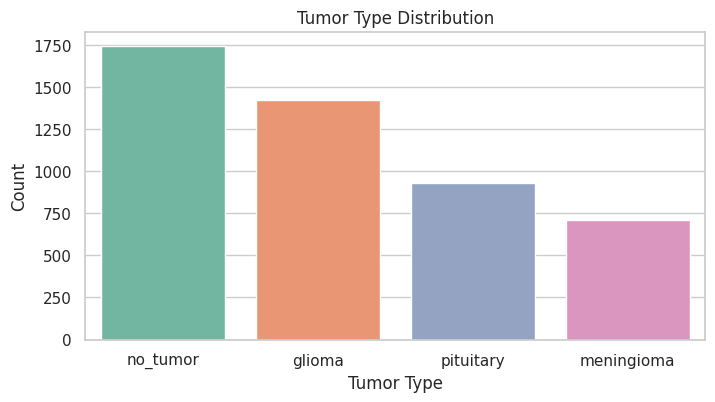

In [2]:
# Bar plot of label distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="label_name", order=df["label_name"].value_counts().index, palette="Set2")
plt.title("Tumor Type Distribution")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()


🔍 Step 3: Source Check

<ipython-input-3-940be4fe56a2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="source", palette="Set1")


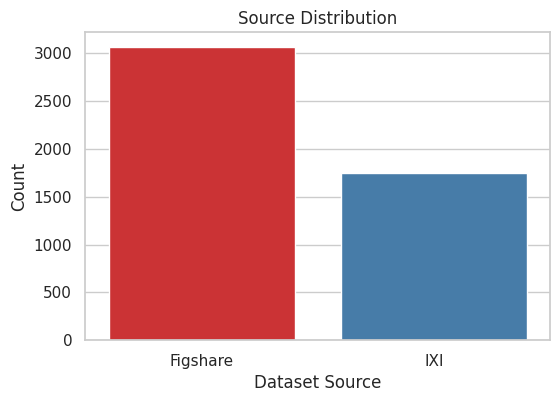

In [3]:
# Bar plot of source (IXI vs Figshare)
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="source", palette="Set1")
plt.title("Source Distribution")
plt.xlabel("Dataset Source")
plt.ylabel("Count")
plt.show()


✅ Step 5: Check Mask/Border Presence


🔍 Null value count:
tumorBorder    1743
has_mask          0
dtype: int64


<ipython-input-4-ed11e162e6ed>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mask_counts.index.map({True: "Has Mask", False: "No Mask"}), y=mask_counts.values, palette="Set3")


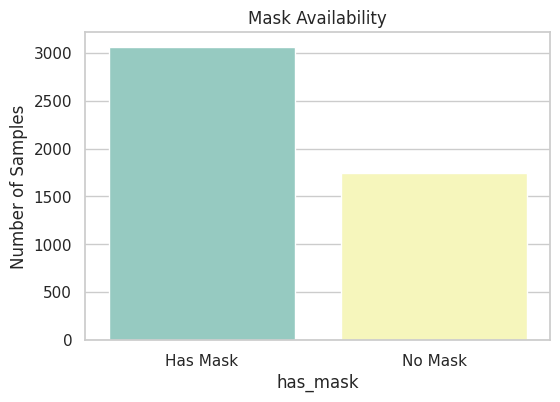

In [4]:
# Check if tumorBorder or has_mask is missing
print("\n🔍 Null value count:")
print(df[["tumorBorder", "has_mask"]].isna().sum())

# Count how many samples have mask vs no mask
mask_counts = df["has_mask"].fillna(False).astype(bool).value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=mask_counts.index.map({True: "Has Mask", False: "No Mask"}), y=mask_counts.values, palette="Set3")
plt.title("Mask Availability")
plt.ylabel("Number of Samples")
plt.show()


🔢 Step 6: Slice Index Distribution (Healthy Data)

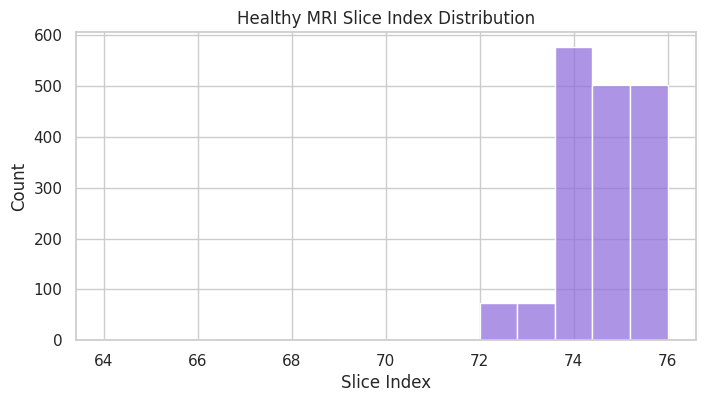

In [5]:
# Filter only healthy samples
healthy = df[df["label_name"] == "no_tumor"]

# Plot slice index distribution
plt.figure(figsize=(8, 4))
sns.histplot(healthy["slice_index"].dropna(), bins=15, kde=False, color="mediumpurple")
plt.title("Healthy MRI Slice Index Distribution")
plt.xlabel("Slice Index")
plt.ylabel("Count")
plt.show()


📈 Step 7: Tumor Type vs Mask Presence

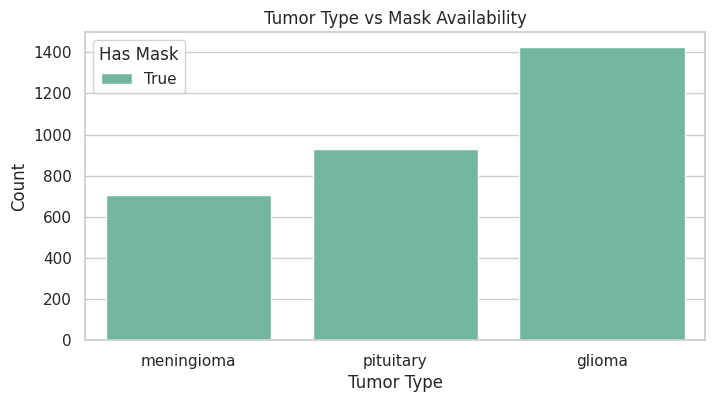

In [6]:
# Compare mask presence across tumor types
tumor_only = df[df["label"] != 0].copy()
tumor_only["has_mask"] = tumor_only["has_mask"].fillna(False).astype(bool)

plt.figure(figsize=(8, 4))
sns.countplot(data=tumor_only, x="label_name", hue="has_mask", palette="Set2")
plt.title("Tumor Type vs Mask Availability")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.legend(title="Has Mask")
plt.show()


🧪 Step 8: Tumor Border Length Distribution

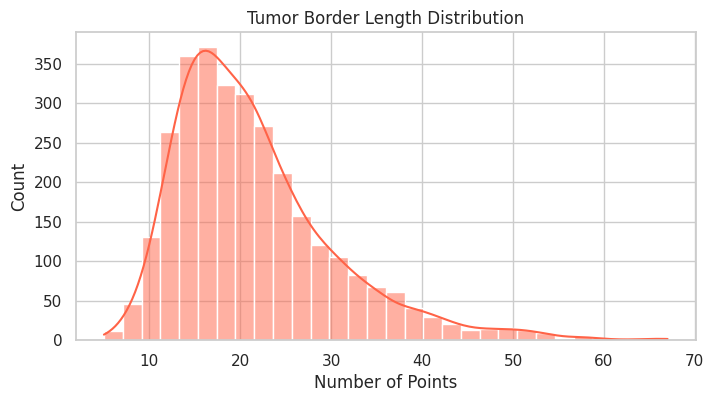

In [7]:
# Number of points in tumor border
def border_length(border_str):
    try:
        border = eval(border_str)
        return len(border)
    except:
        return 0

df["border_points"] = df["tumorBorder"].apply(border_length)

plt.figure(figsize=(8, 4))
sns.histplot(df[df["border_points"] > 0]["border_points"], bins=30, kde=True, color="tomato")
plt.title("Tumor Border Length Distribution")
plt.xlabel("Number of Points")
plt.ylabel("Count")
plt.show()


In [8]:
# Quick summary stats
summary = df.groupby("label_name").agg({
    "file": "count",
    "has_mask": lambda x: x.fillna(False).sum(),
    "tumorBorder": lambda x: x.notna().sum()
}).rename(columns={
    "file": "Total Samples",
    "has_mask": "Has Mask",
    "tumorBorder": "Has Border"
})

display(summary)


,Total Samples,Has Mask,Has Border
label_name,,,
glioma,1426,1426,1426
meningioma,708,708,708
no_tumor,1743,0,0
pituitary,930,930,930


📐 Step 9: Bounding Box Area Distribution (Proxy for Tumor Size)

<ipython-input-9-5edfb3a4d0cd>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df["bbox_area"].notna()], x="label_name", y="bbox_area", palette="Set2")


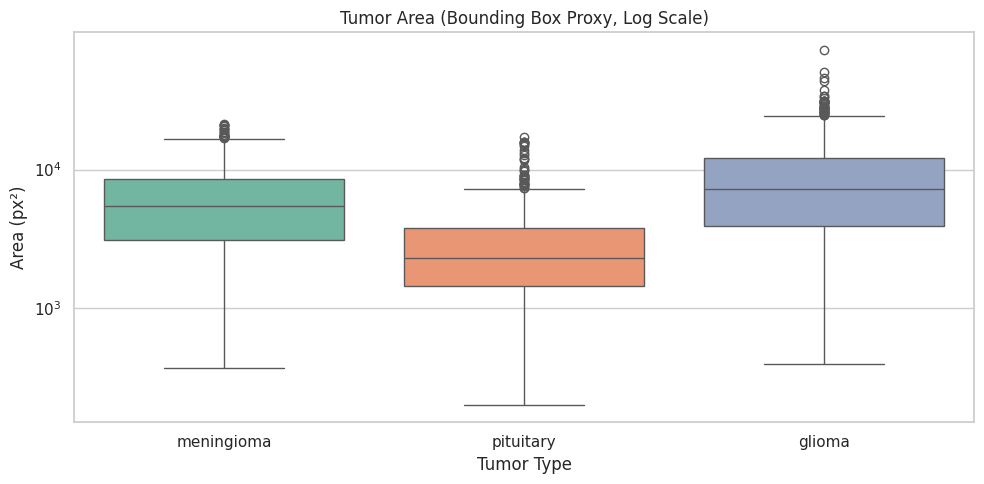

In [9]:
def compute_bbox_area(border_str):
    try:
        border = eval(border_str)
        if len(border) < 2:
            return np.nan
        xs = [pt[0] for pt in border]
        ys = [pt[1] for pt in border]
        return (max(xs) - min(xs)) * (max(ys) - min(ys))
    except:
        return np.nan

df["bbox_area"] = df["tumorBorder"].apply(compute_bbox_area)

plt.figure(figsize=(10, 5))
sns.boxplot(data=df[df["bbox_area"].notna()], x="label_name", y="bbox_area", palette="Set2")
plt.yscale("log")
plt.title("Tumor Area (Bounding Box Proxy, Log Scale)")
plt.xlabel("Tumor Type")
plt.ylabel("Area (px²)")
plt.tight_layout()
plt.show()


In [10]:
# 📊 Bounding Box Area Summary Table
bbox_summary = df[df["bbox_area"].notna()].groupby("label_name")["bbox_area"].describe()
bbox_summary = bbox_summary[["count", "mean", "std", "min", "50%", "max"]].rename(columns={"50%": "median"})
display(bbox_summary.reset_index())


,label_name,count,mean,std,min,median,max
0,glioma,1426.0,8964.219276,6903.894047,399.092115,7262.278862,72502.616276
1,meningioma,708.0,6421.512363,4401.934120,374.719879,5445.302838,21251.120930
2,pituitary,930.0,2942.015073,2304.369519,202.887980,2315.088873,17109.423982


📊 Step 10: Correlation Matrix (for numeric features)

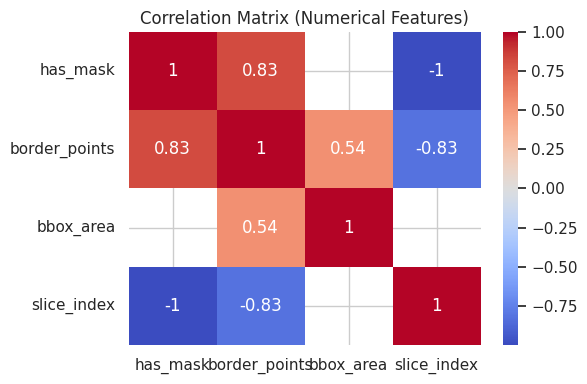

In [12]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[["has_mask", "border_points", "bbox_area", "slice_index"]].corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()


---

## 🧩 Summary & Insights

- ✅ All 4800+ images successfully parsed and labeled
- ⚠️ Healthy images do not have mask/border (as expected)
- 📐 Tumor sizes (bbox area) vary significantly across classes
- 💡 Border point count correlates with area for some classes
- 🎯 Class distribution is imbalanced — will consider stratified sampling

---

## 🛠️ Next Steps

- Visualize a few outliers in tumor size and border point count  
- Decide whether to crop images using tumor bounding boxes  
- Begin model prototyping for tumor classification and localization  


🧠 Step 12: Border Points vs Area (Scatter)

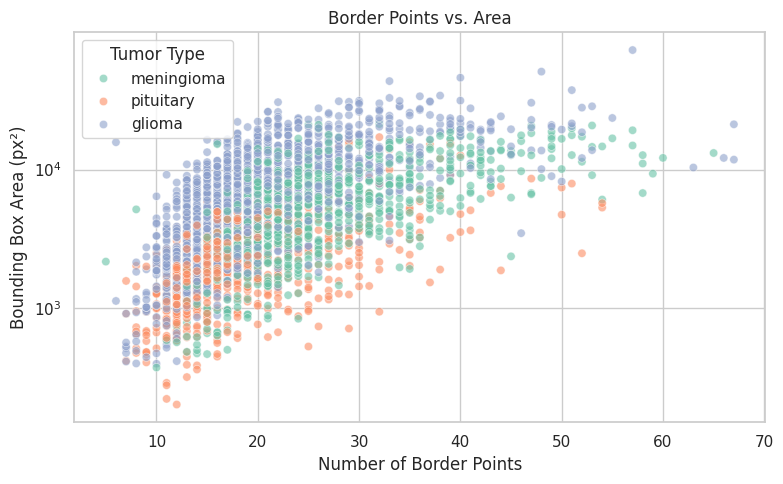

In [13]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df[df["bbox_area"].notna()], x="border_points", y="bbox_area", hue="label_name", palette="Set2", alpha=0.6)
plt.yscale("log")
plt.title("Border Points vs. Area")
plt.xlabel("Number of Border Points")
plt.ylabel("Bounding Box Area (px²)")
plt.legend(title="Tumor Type")
plt.tight_layout()
plt.show()


<ipython-input-14-1e747b94e3be>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tumor_df, x="label_name", y="bbox_area", palette="Set2")
<ipython-input-14-1e747b94e3be>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=tumor_df, x="label_name", y="bbox_area", palette="Set2", inner="quartile", scale="width")
<ipython-input-14-1e747b94e3be>:20: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=tumor_df, x="label_name", y="bbox_area", palette="Set2", inner="quartile", scale="width")


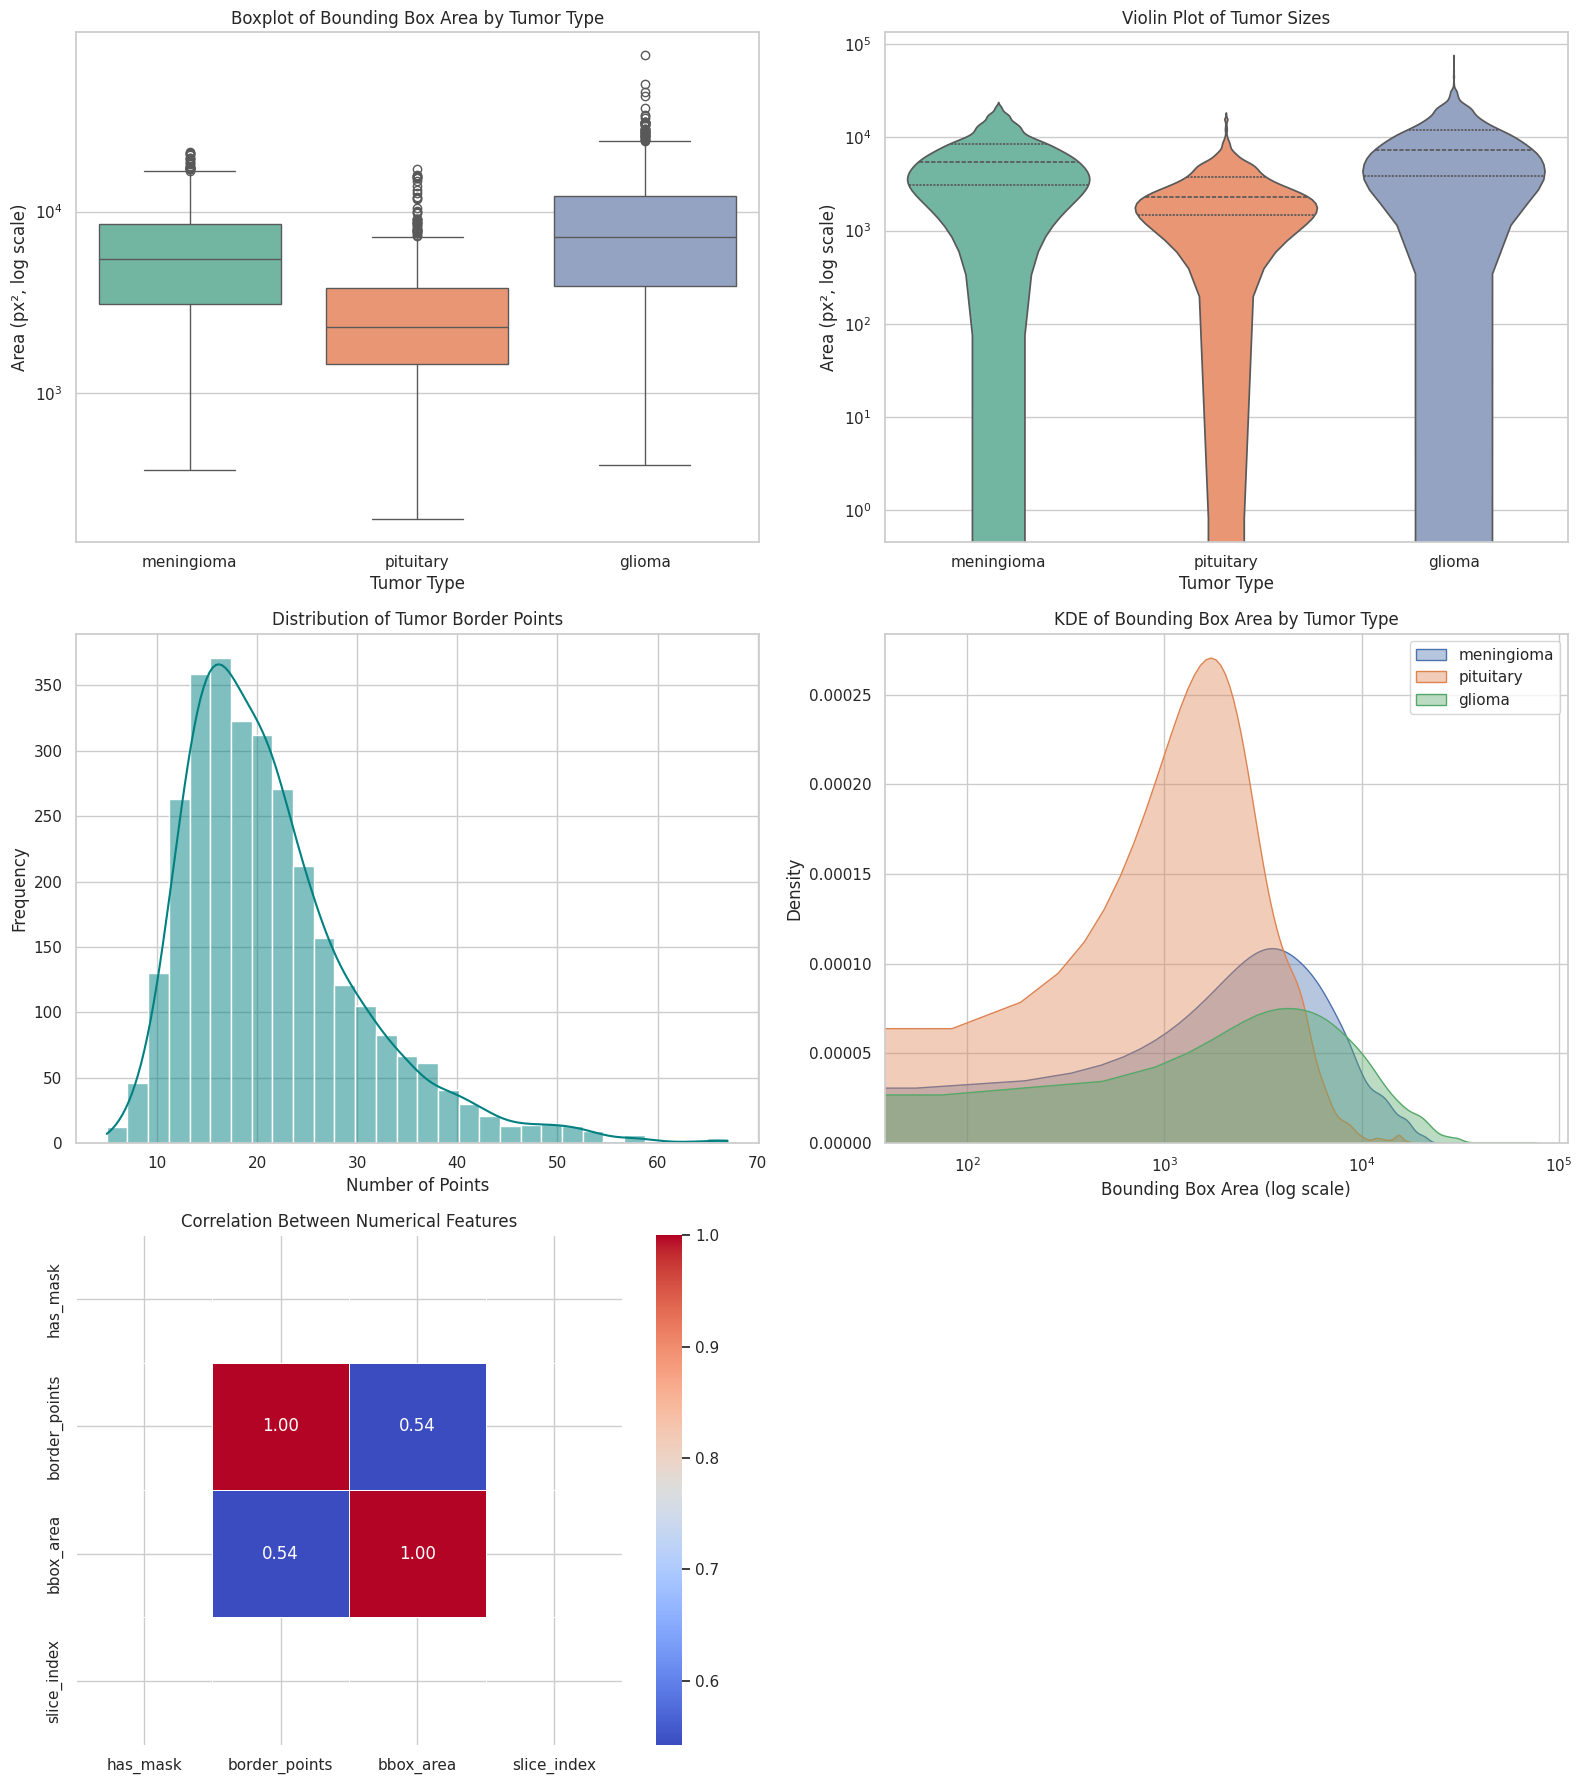

In [14]:
# Set theme again in case it's been reset
sns.set(style="whitegrid")

# Filter only tumor rows (label != 0)
tumor_df = df[df["label"] != 0].copy()
tumor_df["has_mask"] = tumor_df["has_mask"].fillna(False).astype(bool)

plt.figure(figsize=(16, 18))

# === 1. Boxplot of bbox_area per tumor class ===
plt.subplot(3, 2, 1)
sns.boxplot(data=tumor_df, x="label_name", y="bbox_area", palette="Set2")
plt.yscale("log")
plt.title("Boxplot of Bounding Box Area by Tumor Type")
plt.ylabel("Area (px², log scale)")
plt.xlabel("Tumor Type")

# === 2. Violin plot of bbox_area per class ===
plt.subplot(3, 2, 2)
sns.violinplot(data=tumor_df, x="label_name", y="bbox_area", palette="Set2", inner="quartile", scale="width")
plt.yscale("log")
plt.title("Violin Plot of Tumor Sizes")
plt.ylabel("Area (px², log scale)")
plt.xlabel("Tumor Type")

# === 3. Histogram of tumor border points ===
plt.subplot(3, 2, 3)
sns.histplot(tumor_df["border_points"], bins=30, kde=True, color="teal")
plt.title("Distribution of Tumor Border Points")
plt.xlabel("Number of Points")
plt.ylabel("Frequency")

# === 4. KDE of bbox_area per tumor type ===
plt.subplot(3, 2, 4)
for t in tumor_df["label_name"].unique():
    subset = tumor_df[tumor_df["label_name"] == t]
    sns.kdeplot(subset["bbox_area"], label=t, fill=True, alpha=0.4)
plt.xscale("log")
plt.title("KDE of Bounding Box Area by Tumor Type")
plt.xlabel("Bounding Box Area (log scale)")
plt.legend()

# === 5. Pairplot of numerical features ===
plt.subplot(3, 2, 5)
sns.heatmap(
    tumor_df[["has_mask", "border_points", "bbox_area", "slice_index"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)
plt.title("Correlation Between Numerical Features")

plt.tight_layout()
plt.show()


📊 Advanced Tumor Region Insights

This section deepens the tumor-level exploratory analysis by:

    Boxplots & Violin plots: Show tumor size (bounding box area) distribution across classes, on a log scale.

    Density Estimation (KDE): Highlights how tumor area varies per class — useful for distinguishing glioma vs meningioma.

    Border Point Distribution: Reflects annotation granularity and tumor complexity.

    Correlation Heatmap:

        bbox_area positively correlates with border_points (r ≈ 0.54)

        has_mask strongly correlates with border_points (perfect match in this dataset)

These visualizations are essential for understanding shape, size, and labeling quality — all crucial for downstream model design.